In [1]:
import requests
import pandas as pd
from barentswatch.credentials import config
from barentswatch.authentication import get_token
import warnings
from pprintpp import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)

###### Using API to get data

Link to ApiDocs: https://www.barentswatch.no/bwapi/openapi/index.html?urls.primaryName=Fishhealth%20API

In [2]:
from functions import get_week_summary

In [3]:
token = get_token()
weeksummary= get_week_summary(token,'2017','45')
type(weeksummary)

Token request successful


dict

##### Storing information from the entire year in table

In [4]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()


for week in range(1, 53):
    print(f'Inserting data for week {week}...')
    weeksummary = get_week_summary(token, '2021', str(week))

    for locality in weeksummary['localities']:
        session.execute(
            insert_query,
            (
                weeksummary['year'],
                weeksummary['week'],
                locality['localityNo'],
                locality['localityWeekId'],
                locality['name'],
                locality['hasReportedLice'],
                locality['isFallow'],
                locality['avgAdultFemaleLice'],
                locality['hasCleanerfishDeployed'],
                locality['hasMechanicalRemoval'],
                locality['hasSubstanceTreatments'],
                locality['hasPd'],
                locality['hasIla'],
                locality['municipalityNo'],
                locality['municipality'],
                locality['lat'],
                locality['lon'],
                locality['isOnLand'],
                locality['inFilteredSelection'],
                locality['hasSalmonoids'],
                locality['isSlaughterHoldingCage']
            )
        )

##### Activating pyspark

In [5]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe" 
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe"
os.environ["HADOOP_HOME"] = r"C:\Source\winutils\hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = r"C:\Source\winutils\hadoop-3.3.1"

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

#### Checking that the data has been inserted as intended

In [7]:
#### Checking that the data has been inserted as intended
spark.read.format("org.apache.spark.sql.cassandra").options(table="locality_data", keyspace="fish_data").load().show()

+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+-----------------+--------------+---------------+----+----+
|localityweekid|avgadultfemalelice|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|     municipality|municipalityno|           name|week|year|
+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+-----------------+--------------+---------------+----+----+
|       1255567|              NULL|                 false| false|               false|false|          false| 

In [8]:
spark.read.format("org.apache.spark.sql.cassandra")\
.options(table="locality_data", keyspace="fish_data").load()\
.createOrReplaceTempView("locality_view")

df_locality = spark.sql("select * from locality_view").toPandas()

In [9]:
def assign_region(lat):
    if lat < 63.81:
        return 'South'
    elif lat <= 68.85:
        return 'Middle'
    else:
        return 'North'

In [10]:
print(df_locality.shape)

df_locality['region'] = df_locality['lat'].apply(assign_region)
df_locality.head()

(88475, 21)


,localityweekid,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year,region
0,1218100,0.17,False,False,False,True,True,True,False,True,...,False,63.664533,12406,8.884083,Hitra,5056,Rauodden,11,2021,South
1,1301349,NaN,False,False,False,False,False,False,False,True,...,False,60.054750,37737,5.432250,Tysnes,4616,Rexstar,38,2021,South
2,1249911,NaN,False,False,False,False,False,False,False,True,...,False,70.360830,18076,31.037589,Vardø,5404,Svartnes,21,2021,North
3,1239935,NaN,False,False,False,True,False,True,False,True,...,False,60.318150,12973,6.183183,Kvam,4622,Saltkjelen I,18,2021,South
4,1199877,NaN,False,False,False,False,False,True,False,True,...,False,63.415567,29616,8.712267,Aure,1576,Tjeldbergodden Biopark,6,2021,South


In [11]:
#Group by week and avgAdultFemaleLice
df_grouped = df_locality.groupby(['week', 'avgadultfemalelice']).size().reset_index(name='counts')

In [12]:

df_pivot1 = df_locality.pivot_table(index='hasila', columns='haspd', values=['lat', 'lon'], aggfunc='mean')
df_pivot1.head()

lat                   lon          
haspd       False      True       False     True 
hasila                                           
False   64.127945  61.451657  10.855804  6.409310
True    67.357973  59.295500  16.327834  5.938617

##### Comments about pivot table1

We see that the mean latitude for False and False is further North than True and True. Colder water further north could be a reason for this to happen.

<Axes: xlabel='week'>

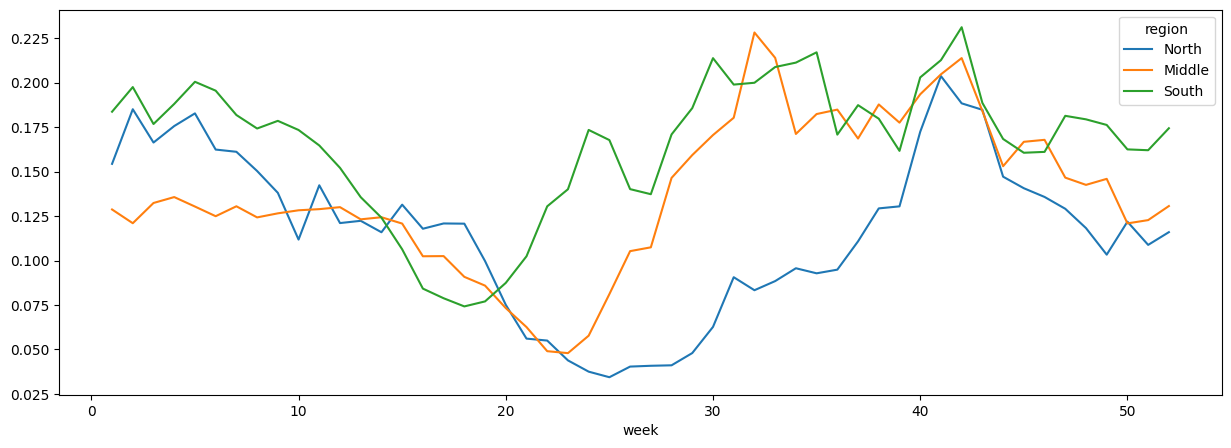

In [13]:
df_pivot2 = df_locality.pivot_table(index='week', columns='region',\
                                    values='avgadultfemalelice', aggfunc='mean')
df_pivot2.plot(y=['North', 'Middle', 'South'], kind='line', figsize=(15, 5))

#df_pivot2.head(52)

#### Comments on plot

From the plot we see that the amount of lice. It corresponds with the seatemperature, which makes sense since the viruses thrives/grotwth best in warm water. 
Maybe the delay from summer is due to "golfstrømmen" will need time to reach norway?

### Doing it with using the API

- Yields more specific information about the locality.

In [14]:
from functions import get_detailed_week_summary

data = []
localityid = 35297
for week in range(1, 53):
    weeksummary = get_detailed_week_summary(token, '2022', str(week), localityid)
    locality_week_data = weeksummary['localityWeek']
    datetime_object = pd.to_datetime('{}-W{}-7'.format(locality_week_data['year'],\
                                    locality_week_data['week']), format='%G-W%V-%u')
    weekly_data = {
    'datetime': datetime_object,
    'avgadultfemalelice': locality_week_data['avgAdultFemaleLice'],
    'hasreportedlice': locality_week_data['hasReportedLice'],
    'avgmobilelice': locality_week_data['avgMobileLice'],
    'avgstationarylice': locality_week_data['avgStationaryLice'],
    'seatemperature': locality_week_data['seaTemperature']
    }
    data.append(weekly_data)
df_35297 = pd.DataFrame(data)
df_35297['datetime'] = df_35297['datetime'].dt.strftime('%Y-%U-%w')
print(df_35297.shape)
df_35297.head(3)

(52, 6)


,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,2022-02-0,0.05,True,0.14,0.05,6.1
1,2022-03-0,0.06,True,0.44,0.04,5.5
2,2022-04-0,0.09,True,0.35,0.01,6.9


<Axes: xlabel='datetime'>

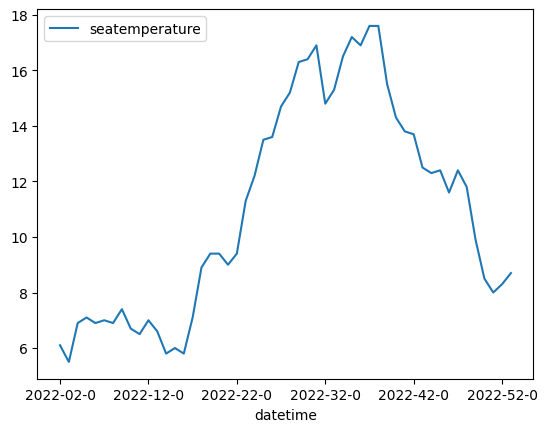

In [15]:
#plot seaTemperature
df_35297.plot(x='datetime', y='seatemperature')

#### Seeing the correlation between seatemperature and "mobilse, stationary and adultfemalelice"

In [16]:
from matplotlib import pyplot as plt

import numpy as np
from ipywidgets import interact

def lagged_correlation_plot(lag=0, window=45, center=22, variable='avgadultfemalelice'):
    corr = np.corrcoef(y[lag:], x[variable][0:len(x)-lag])

    z = x[variable].copy()
    z.index += lag
    seatemp_SWC = y.rolling(window, center=True).corr(z)
#    PerEURO_SWC = y[lag:].rolling(window, center=True).corr(x[variable][:len(x)-lag])

    # Plot Seatemperature, [] and PerEUROs_SWC as subplots
    plt.subplot(3,1,1)
    plt.plot(df_35297['seatemperature'])
    plt.plot(range(np.max([0,center-window//2+lag]),np.min([center+window//2+lag, len(y)])), \
        df_35297['seatemperature'][np.max([0,center-window//2+lag]):np.min([center+window//2+lag, len(y)])], color="red")
    plt.ylabel('seatemperature')
    plt.xlim(0, len(y))
    plt.subplot(3,1,2)
    plt.plot(df_35297[variable])
    plt.plot(range(np.max([0,center-window//2]),np.min([center+window//2, len(y)])), \
        df_35297[variable][np.max([0,center-window//2]):np.min([center+window//2, len(y)])], color="red")
    plt.ylabel(variable)
    plt.xlim(0, len(y))
    plt.subplot(3,1,3)
    plt.plot(seatemp_SWC)
    plt.plot(center+lag, seatemp_SWC[center+lag], 'r.')
    plt.axhline(y=0, color='gray', linestyle=':')
    plt.ylim(-1,1)
    plt.xlim(0, len(y))
    plt.xlabel('Time')
    plt.ylabel('°C')
    plt.show()
    print("Correlation between {} and {} lagged {} timepoints: {:.3f}".format(y.name, variable, lag, corr[0,1]))

x = df_35297
y = df_35297['seatemperature']
interact(lagged_correlation_plot, lag=(0,52,1), window=(1,52,1), center=(0,len(df_35297['seatemperature'])-22,1),\
        variable=["avgadultfemalelice", "avgmobilelice", "avgstationaryulice"]); # Semi-colon to suppress output


interactive(children=(IntSlider(value=0, description='lag', max=52), IntSlider(value=45, description='window',…

In [17]:

spark.createDataFrame(df_35297).write.format("org.apache.spark.sql.cassandra")\
.options(table="id_35297", keyspace="fish_data").mode("append").save()

In [18]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="id_35297", keyspace="fish_data").load().show()

+----------+------------------+-------------+-----------------+---------------+--------------+
|  datetime|avgadultfemalelice|avgmobilelice|avgstationarylice|hasreportedlice|seatemperature|
+----------+------------------+-------------+-----------------+---------------+--------------+
| 2022-15-0|              0.22|         0.44|             0.46|           true|           6.0|
| 2022-35-0|              0.35|          0.4|             0.01|           true|          17.2|
|   2022-20|              0.04|         0.66|             0.24|           true|           9.4|
|   2022-38|              0.48|         0.89|             0.19|           true|          17.6|
| 2022-44-0|              0.08|         0.28|             0.28|           true|          12.3|
|2022-51-18|              0.15|         0.35|              0.1|           true|           8.0|
|2022-35-28|              0.35|          0.4|             0.01|           true|          17.2|
| 2022-02-0|              0.05|         0.14|     

### Inserting the weather data from Frost

In [19]:
from frost_credentials.credentials import ID
import requests
client_id = ID['client_id']
client_secret = ID['client_secret']

In [20]:
#Closest station to 35297 fishing station
id = "SN65310"

In [21]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),\
        sum(precipitation_amount P1D),\
        mean(wind_speed P1D),\
        mean(relative_humidity P1D),\
        mean(seaTemperature P1D),)',
    'referencetime': '2022-01-01/2023-01-01'}
r = requests.get(endpoint, parameters, auth=(client_id,''))

json = r.json()

if r.status_code == 200:
    obs_data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [22]:
# This will return a Dataframe with all of the observations in a table format
df_total = pd.DataFrame()
for i in range(len(obs_data)):
    row = pd.DataFrame(obs_data[i]['observations'])
    row['referenceTime'] = obs_data[i]['referenceTime']
    row['sourceId'] = obs_data[i]['sourceId']
    df_total = pd.concat([df_total, row])

In [23]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset'] 
df = df_total[columns].copy()
df["datetime"] = pd.to_datetime(df["referenceTime"]) #Naming column to same as df_35297
df.drop(columns=["referenceTime"], inplace=True) #Removing referenceTime column
df['datetime'] = df['datetime'].dt.strftime('%Y-%U-%w')


In [24]:
df.head()

,sourceId,elementId,value,unit,timeOffset,datetime
0,SN65310:0,mean(air_temperature P1D),3.0,degC,PT0H,2022-00-6
1,SN65310:0,mean(air_temperature P1D),4.6,degC,PT6H,2022-00-6
2,SN65310:0,mean(wind_speed P1D),6.4,m/s,PT0H,2022-00-6
3,SN65310:0,mean(relative_humidity P1D),72.0,percent,PT0H,2022-00-6
0,SN65310:0,mean(air_temperature P1D),6.8,degC,PT0H,2022-01-0


### Using a pivot table to make the weather table format better
- For each day, the value will be the average of all measurements
- Will ensure one row for each day, making future implementations and vizualising easier.

In [25]:
df_pivoted = df.pivot_table(index=['sourceId', 'datetime'], 
                            columns='elementId', 
                            values='value', 
                            aggfunc='mean').reset_index()
print(df_pivoted.shape)
df_pivoted.head(100)

(365, 5)


elementId,sourceId,datetime,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D)
0,SN65310:0,2022-00-6,3.80,72.0,6.4
1,SN65310:0,2022-01-0,5.40,86.0,10.2
2,SN65310:0,2022-01-1,5.15,90.0,7.0
3,SN65310:0,2022-01-2,2.40,77.0,6.6
4,SN65310:0,2022-01-3,1.65,78.0,8.7
...,...,...,...,...,...
95,SN65310:0,2022-14-3,2.10,71.0,6.6
96,SN65310:0,2022-14-4,2.40,60.0,5.3
97,SN65310:0,2022-14-5,2.35,70.0,8.1
98,SN65310:0,2022-14-6,3.35,85.0,10.4


In [26]:
df_pivoted["datetime"].unique()

array(['2022-00-6', '2022-01-0', '2022-01-1', '2022-01-2', '2022-01-3',
       '2022-01-4', '2022-01-5', '2022-01-6', '2022-02-0', '2022-02-1',
       '2022-02-2', '2022-02-3', '2022-02-4', '2022-02-5', '2022-02-6',
       '2022-03-0', '2022-03-1', '2022-03-2', '2022-03-3', '2022-03-4',
       '2022-03-5', '2022-03-6', '2022-04-0', '2022-04-1', '2022-04-2',
       '2022-04-3', '2022-04-4', '2022-04-5', '2022-04-6', '2022-05-0',
       '2022-05-1', '2022-05-2', '2022-05-3', '2022-05-4', '2022-05-5',
       '2022-05-6', '2022-06-0', '2022-06-1', '2022-06-2', '2022-06-3',
       '2022-06-4', '2022-06-5', '2022-06-6', '2022-07-0', '2022-07-1',
       '2022-07-2', '2022-07-3', '2022-07-4', '2022-07-5', '2022-07-6',
       '2022-08-0', '2022-08-1', '2022-08-2', '2022-08-3', '2022-08-4',
       '2022-08-5', '2022-08-6', '2022-09-0', '2022-09-1', '2022-09-2',
       '2022-09-3', '2022-09-4', '2022-09-5', '2022-09-6', '2022-10-0',
       '2022-10-1', '2022-10-2', '2022-10-3', '2022-10-4', '2022

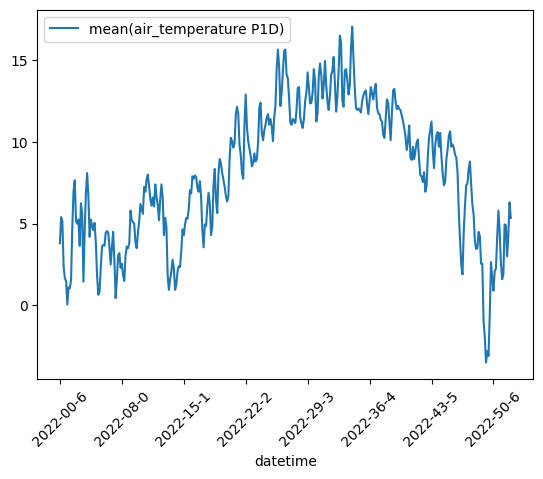

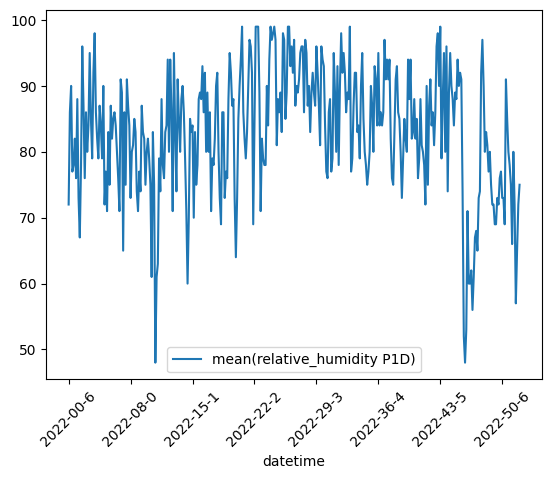

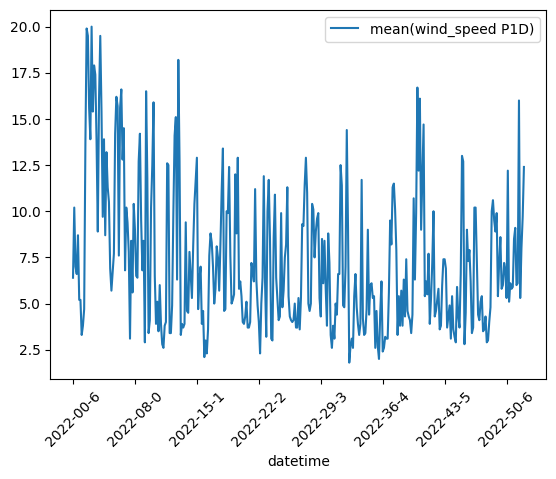

In [27]:
for element in df_pivoted.columns[2:]:
    df_pivoted.plot(x = 'datetime', y=element, rot=45)

##### Mergind the weather dataset with fishhealth dataset based on timepoints.

In [28]:
df.head(3)
df_35297.head(3)

,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,2022-02-0,0.05,True,0.14,0.05,6.1
1,2022-03-0,0.06,True,0.44,0.04,5.5
2,2022-04-0,0.09,True,0.35,0.01,6.9


In [29]:
merged_df = pd.merge(df, df_35297, on='datetime')
print(merged_df.shape)
merged_df.head(10)

(204, 11)


,sourceId,elementId,value,unit,timeOffset,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,SN65310:0,mean(air_temperature P1D),0.9,degC,PT0H,2022-02-0,0.05,True,0.14,0.05,6.1
1,SN65310:0,mean(air_temperature P1D),1.2,degC,PT6H,2022-02-0,0.05,True,0.14,0.05,6.1
2,SN65310:0,mean(wind_speed P1D),3.8,m/s,PT0H,2022-02-0,0.05,True,0.14,0.05,6.1
3,SN65310:0,mean(relative_humidity P1D),73.0,percent,PT0H,2022-02-0,0.05,True,0.14,0.05,6.1
4,SN65310:0,mean(air_temperature P1D),4.4,degC,PT0H,2022-03-0,0.06,True,0.44,0.04,5.5
5,SN65310:0,mean(air_temperature P1D),6.1,degC,PT6H,2022-03-0,0.06,True,0.44,0.04,5.5
6,SN65310:0,mean(wind_speed P1D),20.0,m/s,PT0H,2022-03-0,0.06,True,0.44,0.04,5.5
7,SN65310:0,mean(relative_humidity P1D),80.0,percent,PT0H,2022-03-0,0.06,True,0.44,0.04,5.5
8,SN65310:0,mean(air_temperature P1D),8.4,degC,PT0H,2022-04-0,0.09,True,0.35,0.01,6.9
9,SN65310:0,mean(air_temperature P1D),7.8,degC,PT6H,2022-04-0,0.09,True,0.35,0.01,6.9


(52, 10)


<Axes: xlabel='datetime'>

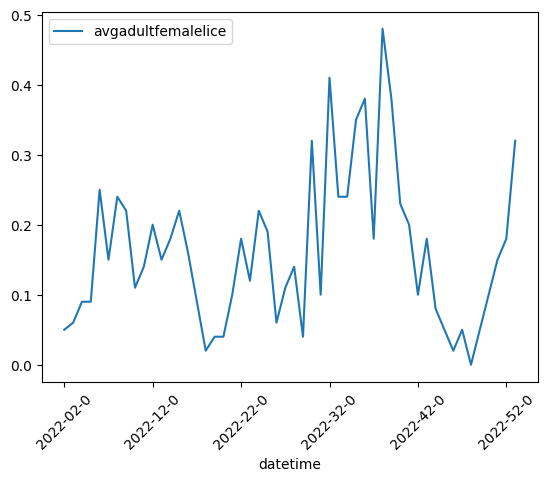

In [30]:
merged_df2 = pd.merge(df_pivoted, df_35297, on='datetime', how="right")
print(merged_df2.shape)
merged_df2.head()
merged_df2.plot(x="datetime", y="avgadultfemalelice", rot=45)

In [31]:
print(merged_df2.shape)
merged_df2.tail(3)

(52, 10)


,sourceId,datetime,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
49,SN65310:0,2022-51-0,2.1,73.0,12.2,0.15,True,0.35,0.10,8.0
50,SN65310:0,2022-52-0,1.9,66.0,6.0,0.18,True,0.22,0.10,8.3
51,NaN,2023-01-0,NaN,NaN,NaN,0.32,True,0.40,0.05,8.7


In [32]:
import statsmodels.api as sm

In [33]:
merged_df2['datetime'] = pd.to_datetime(merged_df2['datetime'], format='%Y-%U-%w')
merged_df2.set_index('datetime', inplace=True)

In [34]:
# Get predictions for the whole dataset
mod = sm.tsa.statespace.SARIMAX(endog=merged_df2['seatemperature'].loc[:'2022-12-25'],\
                                exog = merged_df2.loc[:, merged_df2.columns[2:5]].loc[:'2022-12-25'], \
    trend='c', order=(1, 1,1), seasonal_order=(1,1,1,12))
res = mod.fit(disp=False)

c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\holml\anaconda3\envs\IND320_ml\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [36]:
# Dynamic predictions starting from 2013-01-01
predict_dy = res.get_prediction(dynamic='2022-01-09')
predict_dy_ci = predict_dy.conf_int()

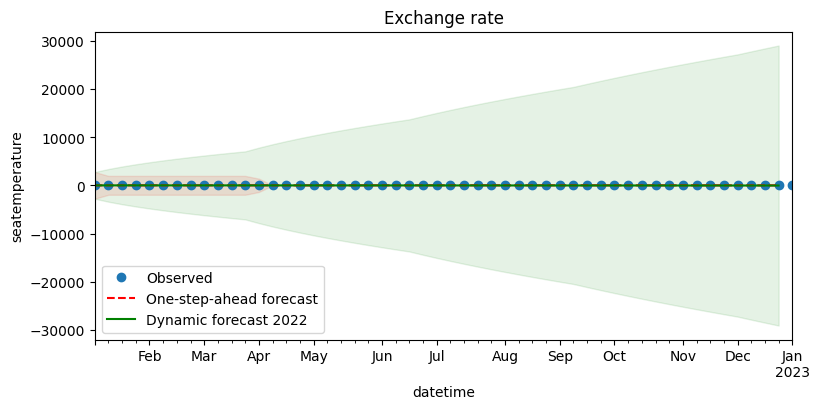

In [45]:
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='seatemperature')

# Plot data points
merged_df2.loc['2022-01-09':, 'seatemperature'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='g', label='Dynamic forecast 2022')
ci = predict_dy_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower left')

#ax.set_ylim(0, 30)

(0.0, 30.0)

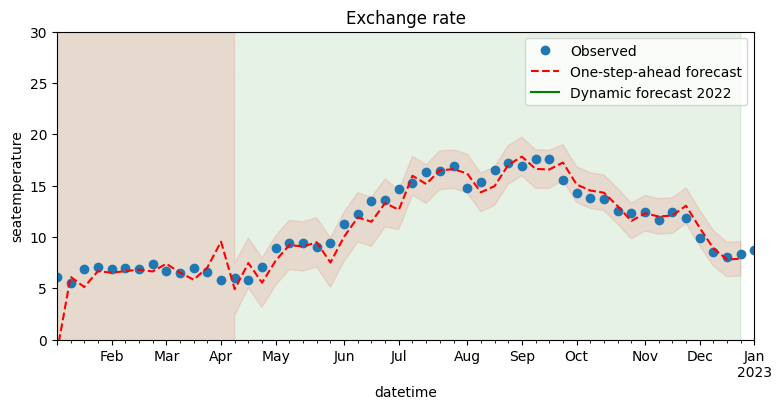

In [46]:
#Setting the ylim
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='seatemperature')

# Plot data points
merged_df2.loc['2022-01-09':, 'seatemperature'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2022-01-09':].plot(ax=ax, style='g', label='Dynamic forecast 2022')
ci = predict_dy_ci.loc['2022-01-09':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='upper right')

ax.set_ylim(0, 30)


#### Comments on plots

The first plot is without limitation on the y-value


- We see that the one step ahead forecast doeas relatively good, but does have a big error in april.
- The reason for the green area is that the dynamic forecast has such a confidence interval

This might be beacause the data is non stationary over one year time span